<a href="https://colab.research.google.com/github/tXiao95/py_experiments/blob/master/XavierInitialization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS 584: Glorot and Bengio: Impact of initializiation


In [1]:
from google.colab import drive
# To Lars: Had to change this filepath from /content/gdrive to /content/drive
drive.mount('/content/drive', force_remount=True)
import sys, os
sys.path.append('/content/drive/My Drive/CS584/Project5')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Import Packages and Load Data



In [0]:
import torch
import torch.nn as nn
# low level access to convolutions
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from torchvision import datasets, transforms

import setupPeaksClass as data


## Generate Train and Test Data

In [0]:
n = 2000;
Y,C = data.getData(n);
C_1D = C.argmax(1)

Ytest,Ctest = data.getData(1000);
Ctest_1D = Ctest.argmax(1)
nf,nc = Y.shape[1], C.shape[1]

# Training the Networks under Initialization

## MLP Class Definition

In [0]:
class MLP(nn.Module):
  def __init__(self, nf, m, nc, act):
    """
    Inherit from nn.Module
    
    Parameters
      nf -- Number of input features
      m -- list of hidden node widths. len(m)=nLayers
      nc -- number of output classes
      act -- activation function
    """
    super().__init__()
    self.nHLayers = len(m)
    self.nf = nf
    self.nc = nc
    self.act = act
    # Z attribute to hold activation values
    self.Z = []
    self.K1 = nn.Linear(nf, m[0])
    for i in range(1, len(m)):
      setattr(self, "K{}".format(i+1), nn.Linear(m[i-1], m[i]))
    self.W = nn.Linear(m[-1], nc)

  def init_weights(self, type):
    for K in self.children():
      if type == "uniform":
        bound = 1 / np.sqrt(K.weight.data.shape[0])
        nn.init.uniform_(K.weight.data, -bound, bound)
      elif type == "xavier":
        nn.init.xavier_uniform_(K.weight.data)
      elif type == "normal":
        nn.init.normal_(K.weight.data)
      nn.init.zeros_(K.bias.data)
      
  def forward(self, Y):
    for i in range(self.nHLayers):
      Y = self.act(getattr(self, "K{}".format(i+1))(Y))
      self.Z.append(Y)
    Y = self.W(Y)
    return Y

  def predict(self, Y):
    pred = self.forward(Y)
    return pred.argmax(1)
    

## Take one step, extract activations and graidents

In [0]:
# Architecture and loss function
m = [10, 20, 50, 100]

nLayer = len(m)
normMLP = MLP(nf, m, nc, torch.tanh)
unifMLP = MLP(nf, m, nc, torch.tanh)
xavierMLP = MLP(nf, m, nc, torch.tanh)

# Initialize weights
normMLP.init_weights("normal")
unifMLP.init_weights("uniform")
xavierMLP.init_weights("xavier")

# Softmax cross entropy loss function
loss_fn = nn.CrossEntropyLoss()

In [88]:
def onestep(model, optimizer, Y, C, loss_fn):
  """One epoch for a model of class MLP"""
  S = model.forward(Y)
  loss = loss_fn(S, C)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss.data

# Optimizers - take one step
normOpt = torch.optim.SGD(normMLP.parameters(), lr=.01)
unifOpt = torch.optim.SGD(unifMLP.parameters(), lr=.01)
xavierOpt = torch.optim.SGD(xavierMLP.parameters(), lr=.01)

# Weird functional programming element to this
onestep(normMLP, normOpt, Y, C_1D, loss_fn)
onestep(unifMLP, unifOpt, Y, C_1D, loss_fn)
onestep(xavierMLP, xavierOpt, Y, C_1D, loss_fn)

tensor(1.5964)

## Function for plot of Activations and Gradients

In [0]:
# Function for plotting activation and gradients
def plotMLP(xavierMLP, normMLP, unifMLP, m):
  # Plot of (nLayer x 2) histograms to show activations and gradients
  fig, axs = plt.subplots(3, 2)
  fig.set_figheight(10)
  fig.set_figwidth(20)

  act_iterable = zip(xavierMLP.Z, normMLP.Z, unifMLP.Z, range(1, 5))
  grad_iterable = zip(xavierMLP.children(), normMLP.children(), 
                     unifMLP.children(), range(1, 5))
  # Gradients
  for X, N, U, k in act_iterable:
    axs[0][0].hist(X.detach().numpy().flatten(), 
            density=True, bins=20, alpha=0.5, label="Layer {}".format(k))
    axs[1][0].hist(N.detach().numpy().flatten(), 
            density=True, bins=20, alpha=0.5, label="Layer {}".format(k))
    axs[2][0].hist(U.detach().numpy().flatten(), 
            density=True, bins=20, alpha=0.5, label="Layer {}".format(k))
  for X, N, U, k in grad_iterable:
    axs[0][1].hist(X.weight.grad.numpy().flatten(), 
            density=True, bins=20, alpha=0.5, label="Layer {}".format(k))
    axs[1][1].hist(N.weight.grad.numpy().flatten(), 
            density=True, bins=20, alpha=0.5, label="Layer {}".format(k))
    axs[2][1].hist(U.weight.grad.numpy().flatten(), 
            density=True, bins=20, alpha=0.5, label="Layer {}".format(k))
  axs[2][1].set_xlim([-3, 3])
  axs[1][1].set_xlim([-3, 3])
  axs[0][0].set_title("Xavier Activation")
  axs[1][0].set_title("N(0,1) Activation")
  axs[2][0].set_title("Unif Activation")
  axs[0][1].set_title("Xavier Gradient")
  axs[1][1].set_title("N(0,1) Gradient")
  axs[2][1].set_title("Unif Gradient")
  plt.legend()
  fig.tight_layout(pad=3.0)


## Activation and Gradient after one Epoch

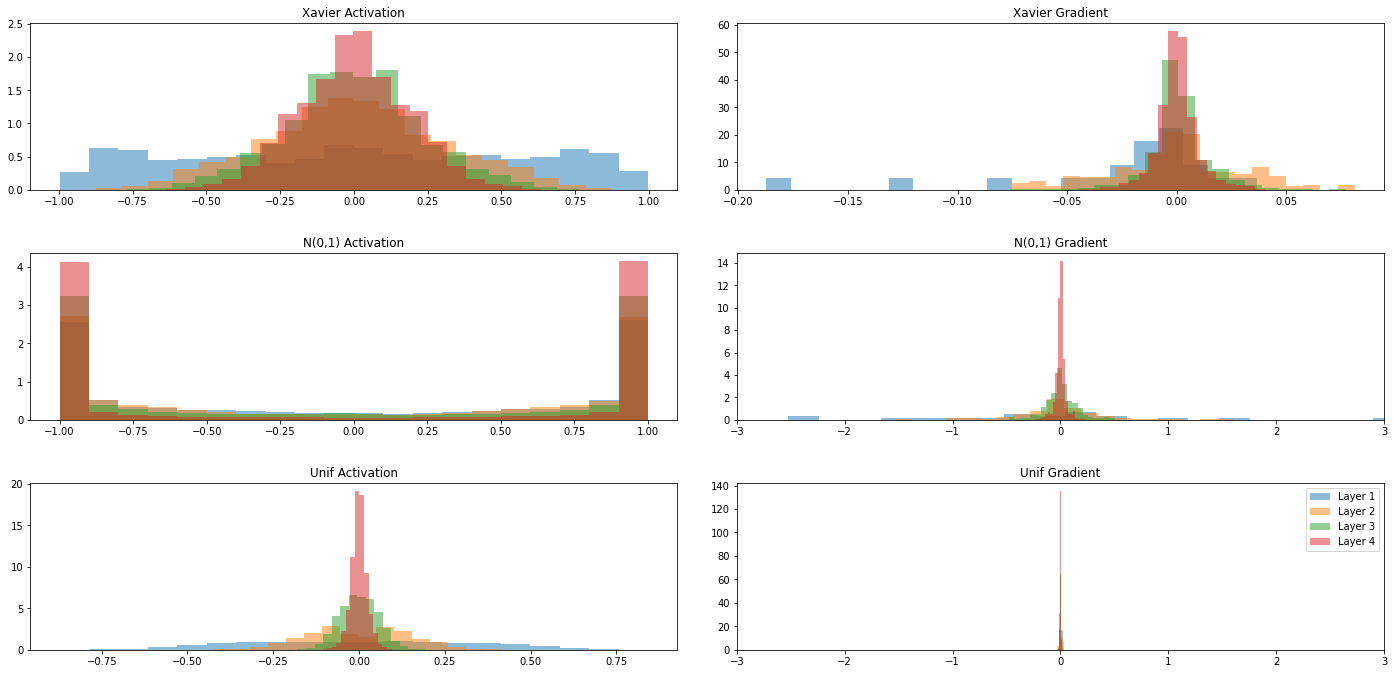

In [90]:
# Plot results from one epoch
plotMLP(xavierMLP, normMLP, unifMLP, m)

The above histograms show activation values and gradients of the weight matrices after one epoch (one forward and backward pass through the network). These results are a little unexpected.

On the activation side, can see that in a forward pass, the activation values look like they start to saturate. This is expected behavior. The saturation increases from Layer 1 (first hidden layer closest to input) to Layer 4, which is also expected due to repeated matrix multiplication. In the normal case, the saturation occurs at the bounds resulting in activations of -1 and 1. In the uniform case, the values get smaller and smaller and concentrate at 0. It's worth pointing out that the distribution of normal gradients is much more spread out compared to the uniform gradients. This would suggest that training for the normal initialization model would proceed more smoothly, due to a wider variety of nonzero gradients from the start. 

When we look at the Xavier initialization weights however, we see that while the distribution of both activation and gradients is much more similar between layers than the standard initialization (which is expected from the paper), the gradient distribution is even more concentrated at 0 at all layers compared to the normal. The gradients range only from -0.10 to 0.15, compared to gradients of up to plus or minus 3 in the other initializations. Just from looking at this first epoch, based on the theory provided in the Xavier paper, the normal looks like it would be the easiest to train (and was not considered in the original paper!). 

One weird thing I'm noticing in the uniform and Xavier histograms is that the gradient layer labels seem to be flipped with what I would expect. The normal makes sense. Layer 4 has the most activation -1's and 1's, so the gradient plot shows Layer 4 has the most zero gradients. However, for Xavier and uniform, Layer 4 has the most activation 0's, and Layer 1 has the more -1 and 1's. Yet, the gradient plot shows Layer 4 has the most zero gradients, when an activation of 0 is where the tanh function has its greatest gradient. I double checked the code and still couldn't find an error. Thought this was surprising.

## Training the Networks

In [91]:
numEpoch = 3000

normLoss = torch.empty(numEpoch)
unifLoss = torch.empty(numEpoch)
xavierLoss = torch.empty(numEpoch)

for i in range(numEpoch):
  normLoss[i] = onestep(normMLP, normOpt, Y, C_1D, loss_fn)
  unifLoss[i] = onestep(unifMLP, unifOpt, Y, C_1D, loss_fn)
  xavierLoss[i] = onestep(xavierMLP, xavierOpt, Y, C_1D, loss_fn)
  if i % 100 == 99:
    print("Iteration {}".format(i))
    print("Normal Loss: {}".format(normLoss[i]))
    print("Uniform Loss: {}".format(unifLoss[i]))
    print("Xavier Loss: {}".format(xavierLoss[i]))

Iteration 99
Normal Loss: 0.6860971450805664
Uniform Loss: 1.3675144910812378
Xavier Loss: 1.195547103881836
Iteration 199
Normal Loss: 0.48435813188552856
Uniform Loss: 1.2200134992599487
Xavier Loss: 1.1230577230453491
Iteration 299
Normal Loss: 0.41716524958610535
Uniform Loss: 1.1677452325820923
Xavier Loss: 1.0866351127624512
Iteration 399
Normal Loss: 0.37350592017173767
Uniform Loss: 1.1365374326705933
Xavier Loss: 1.0604103803634644
Iteration 499
Normal Loss: 0.3395431935787201
Uniform Loss: 1.113848090171814
Xavier Loss: 1.0380454063415527
Iteration 599
Normal Loss: 0.314180463552475
Uniform Loss: 1.0957045555114746
Xavier Loss: 1.01738703250885
Iteration 699
Normal Loss: 0.2945176362991333
Uniform Loss: 1.079982042312622
Xavier Loss: 0.9975019693374634
Iteration 799
Normal Loss: 0.2781621515750885
Uniform Loss: 1.0652128458023071
Xavier Loss: 0.9779857993125916
Iteration 899
Normal Loss: 0.2639678120613098
Uniform Loss: 1.0505446195602417
Xavier Loss: 0.9587163925170898
Itera

## Activation and Gradient Plot for the final iteration

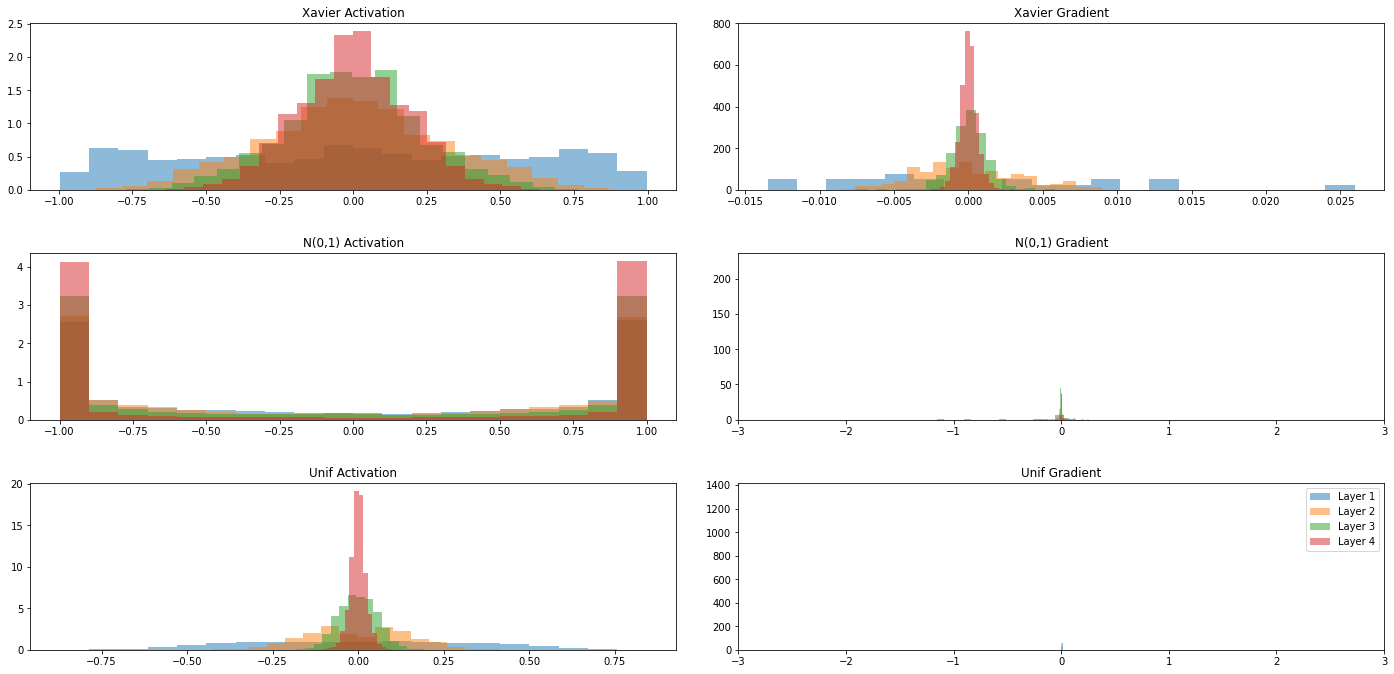

In [101]:
plotMLP(xavierMLP, normMLP, unifMLP, m)

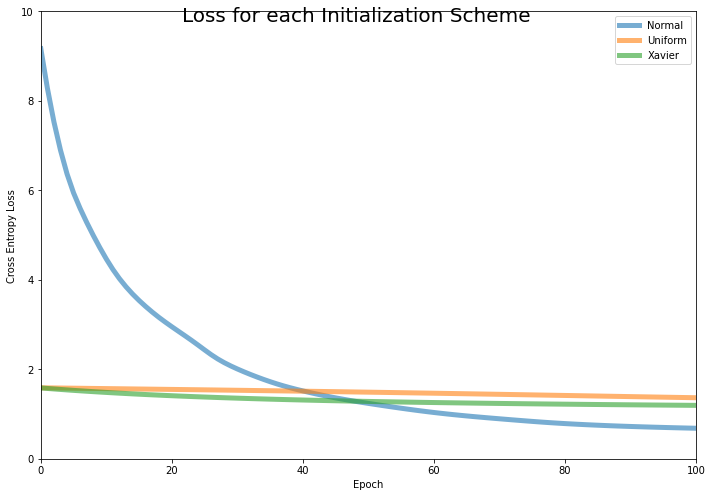

In [99]:
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(10)
ax.plot(normLoss, label="Normal", linewidth=5, alpha=0.6)
ax.plot(unifLoss, label="Uniform", linewidth=5, alpha=0.6)
ax.plot(xavierLoss, label="Xavier", linewidth=5, alpha=0.6)
ax.set_xlabel("Epoch")
ax.set_ylabel("Cross Entropy Loss")
ax.set_xlim([0, 100])
ax.set_ylim([0, 10])
plt.legend()
fig.suptitle("Loss for each Initialization Scheme", fontsize=20)
fig.tight_layout()

In [0]:
def error(model, Y, C):
  """Compute accuracy of MLP model"""
  return np.mean((model.predict(Y) == C).detach().numpy())
normTrainAcc = error(normMLP, Y, C_1D)
normTestAcc = error(normMLP, Ytest, Ctest_1D)
unifTrainAcc = error(unifMLP, Y, C_1D)
unifTestAcc = error(unifMLP, Ytest, Ctest_1D)
xavierTrainAcc = error(xavierMLP, Y, C_1D)
xavierTestAcc = error(xavierMLP, Ytest, Ctest_1D)

In [98]:
pd.DataFrame({"train":[normTrainAcc, unifTrainAcc, xavierTrainAcc], 
              "test":[normTestAcc, unifTestAcc, xavierTestAcc]}, 
             index=["Normal", "Uniform", "Xavier"])

,train,test
Normal,0.9675,0.937
Uniform,0.7745,0.702
Xavier,0.7620,0.749


After 3000 epochs with `optim`'s stochastic gradient descent method with learning rate 0.01, the standard normal initialization actually performed the best. Based on the loss plot, it does seem that the Xavier and uniform initial weight activation and gradients support what's seen here. The loss never decreased drastically, from the start they were already at a space where the gradient was close to 0, and got stuck. Meanwhile, the normal started off with higher loss, but much more room to learn and eventually had a loss less than the other two. 

More playing around with the optimization method could lead to different results, but this is an interesting case where Xavier initialization underperformed a common initialization method in the standard normal.